In [14]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import os
import glob
import cv2
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from albumentations import HorizontalFlip, VerticalFlip, Rotate
import tqdm
import torch.nn.functional as F
import matplotlib.image as mpimg
from skimage.filters import unsharp_mask

In [15]:
torch.manual_seed(42)
np.random.seed(42)
torch.cuda.manual_seed_all(42)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False

In [16]:
size = (256, 256)

In [17]:
class LoadData(Dataset):
    def __init__(self, images_path, masks_path):
        super().__init__()

        self.images_path = images_path
        self.masks_path = masks_path
        self.len = len(images_path)
        self.transform = transforms.Resize(size)

    def __getitem__(self, idx):
        img = Image.open(self.images_path[idx])
        img = self.transform(img)
        img = np.transpose(img, (2, 0, 1))
        img = img/255.0
        img = unsharp_mask(img, radius=5, amount=2)
        img = torch.tensor(img)

        mask = Image.open(self.masks_path[idx]).convert('L')
        mask = self.transform(mask)
        mask = np.expand_dims(mask, axis=0)
        mask = mask/255.0
        mask = torch.tensor(mask)

        return img, mask
    
    def __len__(self):
        return self.len

In [18]:
X = sorted(glob.glob('../input/satellite-images-of-water-bodies/Water Bodies Dataset/Images/*'))
y = sorted(glob.glob('../input/satellite-images-of-water-bodies/Water Bodies Dataset/Masks/*'))


In [19]:
X[0]

'../input/satellite-images-of-water-bodies/Water Bodies Dataset/Images/water_body_1.jpg'

In [20]:
len(X)

2841

In [21]:
train_X = X[:2800]
train_y = y[:2800]

In [22]:
len(train_X)

2800

In [23]:
valid_X = X[2800:]
valid_y = y[2800:]

In [24]:
len(valid_X)

41

In [25]:
train_dataset = LoadData(train_X, train_y)
valid_dataset = LoadData(valid_X, valid_y)

In [26]:
img, mask = train_dataset[0]

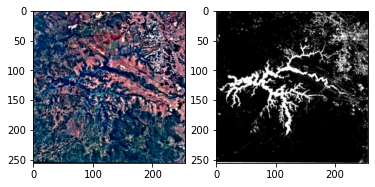

In [27]:
f, axarr = plt.subplots(1,2) 
axarr[1].imshow(np.squeeze(mask.numpy()), cmap='gray')
axarr[0].imshow(np.transpose(img.numpy(), (1,2,0)))

In [28]:
img.shape

torch.Size([3, 256, 256])

In [29]:
class conv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU()
    
    def forward(self, images):
        x = self.conv1(images)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        return x


In [30]:
class encoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv = conv(in_channels, out_channels)
        self.pool = nn.MaxPool2d((2,2))

    def forward(self, images):
        x = self.conv(images)
        p = self.pool(x)

        return x, p

In [31]:
class decoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2, padding=0)
        self.conv = conv(out_channels * 2, out_channels)

    def forward(self, images, prev):
        x = self.upconv(images)
        x = torch.cat([x, prev], axis=1)
        x = self.conv(x)

        return x


In [32]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.e1 = encoder(3, 64)
        self.e2 = encoder(64, 128)
        self.e3 = encoder(128, 256)
        self.e4 = encoder(256, 512)

        self.b = conv(512, 1024)

        self.d1 = decoder(1024, 512)
        self.d2 = decoder(512, 256)
        self.d3 = decoder(256, 128)
        self.d4 = decoder(128, 64)

        self.output = nn.Conv2d(64, 1, kernel_size=1, padding=0)

    def forward(self, images):
        x1, p1 = self.e1(images)
        x2, p2 = self.e2(p1)
        x3, p3 = self.e3(p2)
        x4, p4 = self.e4(p3)

        b = self.b(p4)
        
        d1 = self.d1(b, x4)
        d2 = self.d2(d1, x3)
        d3 = self.d3(d2, x2)
        d4 = self.d4(d3, x1)

        output_mask = self.output(d4)

        return output_mask      

In [33]:
batch_size = 4
num_epochs = 12
lr = 1e-4
checkpoint_path = "./checkpoint.pth"


In [34]:
train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
)

valid_loader = DataLoader(
        dataset=valid_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
)

In [35]:
device = torch.device('cuda')
model = UNet()
model = model.to(device)

In [36]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        inputs = torch.sigmoid(inputs)
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_score = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        dice_loss = 1 - dice_score
        loss = torch.nn.BCELoss()
        BCE = loss(inputs, targets)
        Dice_BCE = BCE + dice_loss

        return Dice_BCE

In [37]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = DiceBCELoss()

In [38]:
def train_model(model, loader, optimizer, loss_fn, device):
    epoch_loss = 0.0

    model.train()
    for x, y in loader:
        x = x.to(device, dtype=torch.float32)
        y = y.to(device, dtype=torch.float32)

        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss = epoch_loss/len(loader)
    return epoch_loss

In [39]:
def evaluate(model, loader, loss_fn, device):
    epoch_loss = 0.0

    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.float32)
#             x,y=x.type(torch.FloatTensor),y.type(torch.FloatTensor)

            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            epoch_loss += loss.item()

        epoch_loss = epoch_loss/len(loader)
    return epoch_loss

In [ ]:
train = []
valid = []

In [40]:


# best_valid_loss = float("inf")

for epoch in range(num_epochs):
        train_loss = train_model(model, train_loader, optimizer, loss_fn, device)
        valid_loss = evaluate(model, valid_loader, loss_fn, device)

        train.append(train_loss)
        valid.append(valid_loss)        
        
        if valid_loss < best_valid_loss:
            data_str = f"Valid loss improved from {best_valid_loss:2.4f} to {valid_loss:2.4f}. Saving checkpoint: {checkpoint_path}"
            print(data_str)

            best_valid_loss = valid_loss
            torch.save(model.state_dict(), checkpoint_path)

        data_str = f'Epoch: {epoch+1:02}\n'
        data_str += f'\tTrain Loss: {train_loss:.3f}\n'
        data_str += f'\t Val. Loss: {valid_loss:.3f}\n'
        print(data_str)

Valid loss improved from inf to 0.6635. Saving checkpoint: ./checkpoint.pth
Epoch: 01
	Train Loss: 0.844
	 Val. Loss: 0.664

Valid loss improved from 0.6635 to 0.5753. Saving checkpoint: ./checkpoint.pth
Epoch: 02
	Train Loss: 0.722
	 Val. Loss: 0.575

Epoch: 03
	Train Loss: 0.667
	 Val. Loss: 0.632

Epoch: 04
	Train Loss: 0.618
	 Val. Loss: 0.688

Valid loss improved from 0.5753 to 0.5461. Saving checkpoint: ./checkpoint.pth
Epoch: 05
	Train Loss: 0.586
	 Val. Loss: 0.546

Epoch: 06
	Train Loss: 0.581
	 Val. Loss: 0.555

Epoch: 07
	Train Loss: 0.553
	 Val. Loss: 0.568

Valid loss improved from 0.5461 to 0.5397. Saving checkpoint: ./checkpoint.pth
Epoch: 08
	Train Loss: 0.533
	 Val. Loss: 0.540

Epoch: 09
	Train Loss: 0.534
	 Val. Loss: 0.546

Valid loss improved from 0.5397 to 0.5021. Saving checkpoint: ./checkpoint.pth
Epoch: 10
	Train Loss: 0.520
	 Val. Loss: 0.502

Epoch: 11
	Train Loss: 0.509
	 Val. Loss: 0.607

Epoch: 12
	Train Loss: 0.496
	 Val. Loss: 0.502



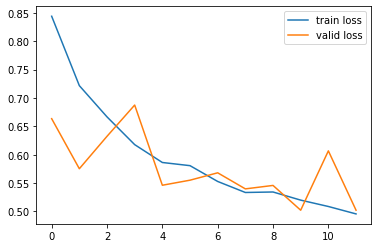

In [48]:
plt.plot(range(0,12), train, label='train loss')
plt.plot(range(0,12), valid, label='valid loss')
plt.legend()

In [41]:
m = UNet()
m.load_state_dict(torch.load(checkpoint_path))
m = m.to(device)

<Figure size 2160x576 with 0 Axes>

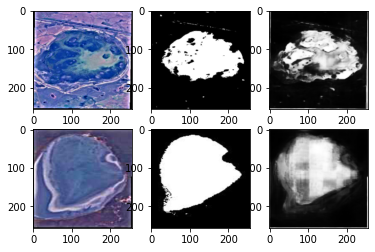

In [43]:
transform = transforms.ToPILImage()
pred = []
for x, y in valid_loader:
    image0 = transform(x[0])
    image1 = transform(x[1])
    
    x = x.to(device, dtype=torch.float32)
    y = y.to(device, dtype=torch.float32)
        
    y_pred = torch.sigmoid(m(x))
    img = y_pred.cpu().detach().numpy()
    plt.figure(figsize=(30,8))

    #subplot(r,c) provide the no. of rows and columns
    f, axarr = plt.subplots(2,3) 

    axarr[0,0].imshow(image0)
    axarr[0,1].imshow(np.squeeze(y.cpu().detach().numpy())[0], cmap='gray')
    axarr[0,2].imshow(np.squeeze(img)[0], cmap='gray')
    
    axarr[1,0].imshow(image1)
    axarr[1,1].imshow(np.squeeze(y.cpu().detach().numpy())[1], cmap='gray')
    axarr[1,2].imshow(np.squeeze(img)[1], cmap='gray')
    break

In [44]:
dice_BCE = evaluate(m, valid_loader, loss_fn, device)

In [45]:
dice_BCE

0.5002132315527309